<a href="https://colab.research.google.com/github/syamala015/forest-fire-detection-using-DL-_week-1/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("elmadafri/the-wildfire-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/the-wildfire-dataset


In [ ]:
# Core Libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

# System Configuration
from tensorflow.config import list_physical_devices

# Display full precision for TensorFlow outputs (optional)
np.set_printoptions(precision=4, suppress=True)


In [ ]:
# Check and configure GPU usage
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU is available and configured.")
    except RuntimeError as e:
        print("GPU configuration error:", e)
else:
    print(" GPU not available. Using CPU.")


GPU is available and configured.


In [ ]:
# Dataset base path (update if needed)
dataset_path = '/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version'

# Sub-directories for training, validation, and test sets
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')
test_dir = os.path.join(dataset_path, 'test')

print(" Dataset directories set.")


 Dataset directories set.


In [ ]:
# Path to training directory
train_dir = '/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/train'

# List class names
classes = sorted(os.listdir(train_dir))

# Display results
print(f" Total number of classes: {len(classes)}")
print(f"Class names: {classes}")


 Total number of classes: 2
Class names: ['fire', 'nofire']


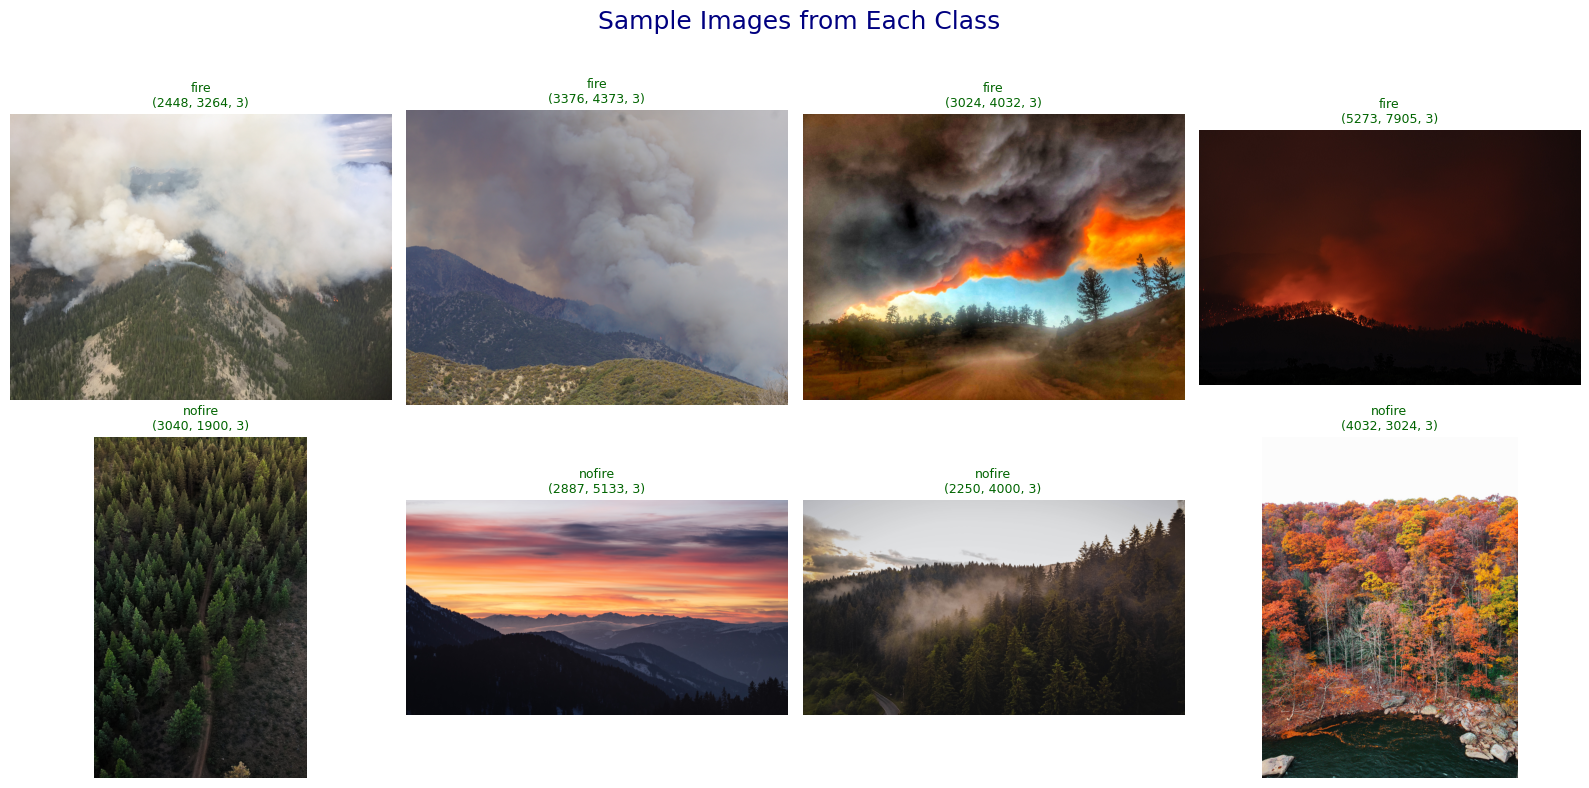

In [ ]:
import matplotlib.pyplot as plt
import os
import random

def visualize_dataset_images(data_dir, class_names, images_per_class=4):
    total_classes = len(class_names)
    plt.figure(figsize=(images_per_class * 4, total_classes * 4))

    for row, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        image_files = os.listdir(class_path)
        selected_images = random.sample(image_files, min(images_per_class, len(image_files)))

        for col, image_name in enumerate(selected_images):
            img_path = os.path.join(class_path, image_name)
            img = plt.imread(img_path)

            plt.subplot(total_classes, images_per_class, row * images_per_class + col + 1)
            plt.imshow(img)
            plt.title(f"{class_name}\n{img.shape}", fontsize=9, color='darkgreen')
            plt.axis('off')

    plt.suptitle(" Sample Images from Each Class", fontsize=18, color='navy')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Usage
visualize_dataset_images(train_dir, classes)


In [ ]:
# Image dimensions and batch size for training
img_width, img_height = 150, 150   # Resize all images to 150x150
batch_size = 32                    # Number of images in one batch

# Data augmentation and rescaling using ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and Test generators only perform rescaling (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow images from directories and apply transformations
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 1887 images belonging to 2 classes.
Found 402 images belonging to 2 classes.
Found 410 images belonging to 2 classes.


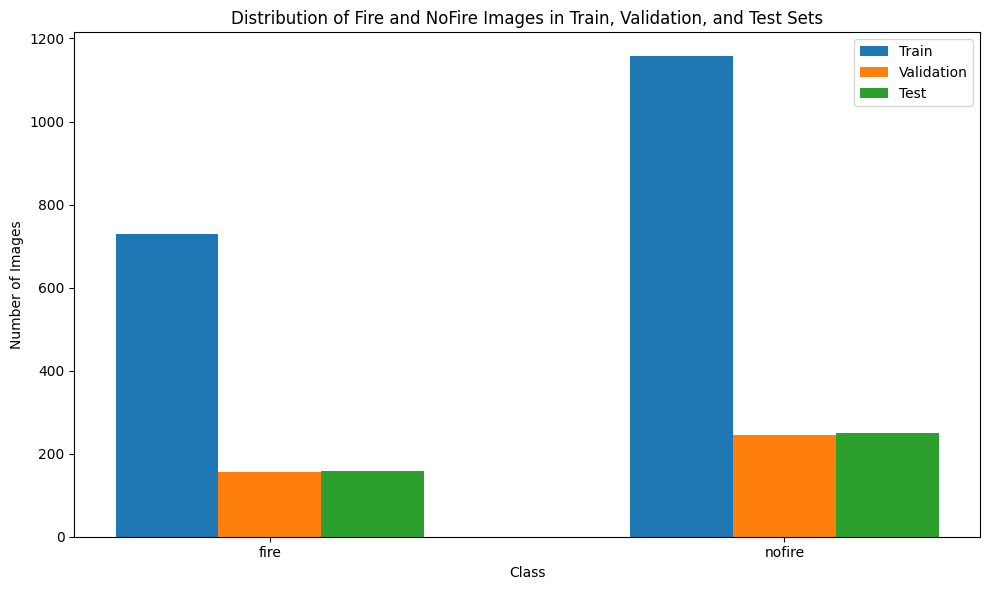

In [ ]:
import matplotlib.pyplot as plt

# Class names and their counts for training, validation, and test datasets
train_counts = [len(os.listdir(os.path.join(train_dir, class_name))) for class_name in classes]
val_counts = [len(os.listdir(os.path.join(val_dir, class_name))) for class_name in classes]
test_counts = [len(os.listdir(os.path.join(test_dir, class_name))) for class_name in classes]

# Bar graph to show the class distribution in train, validation, and test datasets
fig, ax = plt.subplots(figsize=(10, 6))

# Define the positions for each bar
x = range(len(classes))

# Plot bars for train, validation, and test datasets
ax.bar(x, train_counts, width=0.2, label='Train', align='center')
ax.bar([p + 0.2 for p in x], val_counts, width=0.2, label='Validation', align='center')
ax.bar([p + 0.4 for p in x], test_counts, width=0.2, label='Test', align='center')

# Labeling the graph
ax.set_xticks([p + 0.2 for p in x])
ax.set_xticklabels(classes)
ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.set_title('Distribution of Fire and NoFire Images in Train, Validation, and Test Sets')
ax.legend()

# Show the graph
plt.tight_layout()
plt.show()




*   If the **bars for fire in the training dataset are much higher** than the **nofire bars**, it suggests that there are **more fire images in the training set,** which could affect how well the model learns.

*  If the validation and test sets have fewer images than the training set, it’s a common practice, as validation and test sets are typically smaller.

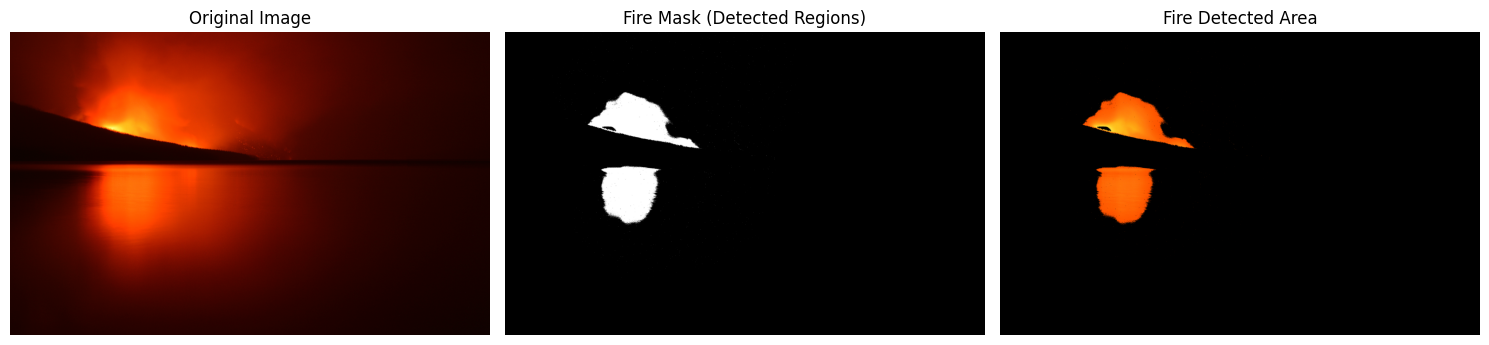

In [ ]:
                                          #fire detection process
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

# Pick a sample fire image
sample_image_path = os.path.join(test_dir, 'fire', fire_images[0])

# Load image using OpenCV
img = cv2.imread(sample_image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert to HSV color space
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Define fire-like color range in HSV
lower_fire = np.array([10, 100, 100])
upper_fire = np.array([25, 255, 255])

# Create a mask for fire color
mask = cv2.inRange(hsv, lower_fire, upper_fire)

# Apply mask to original image
fire_highlighted = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)

# Plot results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title("Fire Mask (Detected Regions)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(fire_highlighted)
plt.title("Fire Detected Area")
plt.axis('off')

plt.tight_layout()
plt.show()




1. Converts the **input image from BGR  to HSV(Hue, Saturation, Value)** .
2. Applies the range to **create a binary mask — areas matching the fire color become white (255), others become black (0).**
3. Applies this **mask back to the original image using bitwise_and to highlight fire-like**regions.
   



In [ ]:
# Build CNN Model for Binary Classification (Fire vs NoFire)
model = Sequential([
    Input(shape=(img_width, img_height, 3)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),

    # Output layer with a single neuron (sigmoid) for binary classification
    Dense(1, activation='sigmoid')
])

# Compile the model with binary crossentropy loss and accuracy metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    21,234,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,327,937 (81.36 MB)

 Trainable params: 21,327,937 (81.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_generator,
    epochs=10,  # or however many you want
    validation_data=val_generator
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
12/59 ━━━━━━━━━━━━━━━━━━━━ 5:24 7s/step - accuracy: 0.5163 - loss: 0.9401

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


26/59 ━━━━━━━━━━━━━━━━━━━━ 3:54 7s/step - accuracy: 0.5677 - loss: 0.8400

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


59/59 ━━━━━━━━━━━━━━━━━━━━ 565s 10s/step - accuracy: 0.6013 - loss: 0.7472 - val_accuracy: 0.6841 - val_loss: 0.5737
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 545s 8s/step - accuracy: 0.7238 - loss: 0.5285 - val_accuracy: 0.7065 - val_loss: 0.5686
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 472s 8s/step - accuracy: 0.7275 - loss: 0.5298 - val_accuracy: 0.7985 - val_loss: 0.4748
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 467s 8s/step - accuracy: 0.7454 - loss: 0.5226 - val_accuracy: 0.7811 - val_loss: 0.4748
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 484s 8s/step - accuracy: 0.7622 - loss: 0.4889 - val_accuracy: 0.7612 - val_loss: 0.4722
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 455s 8s/step - accuracy: 0.7529 - loss: 0.5035 - val_accuracy: 0.7836 - val_loss: 0.4487
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 463s 8s/step - accuracy: 0.7585 - loss: 0.4895 - val_accuracy: 0.7910 - val_loss: 0.4368
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 459s 8s/step - accuracy: 0.7757 - loss: 0.4610 - val_accuracy: 0.8109 - val_loss: 0

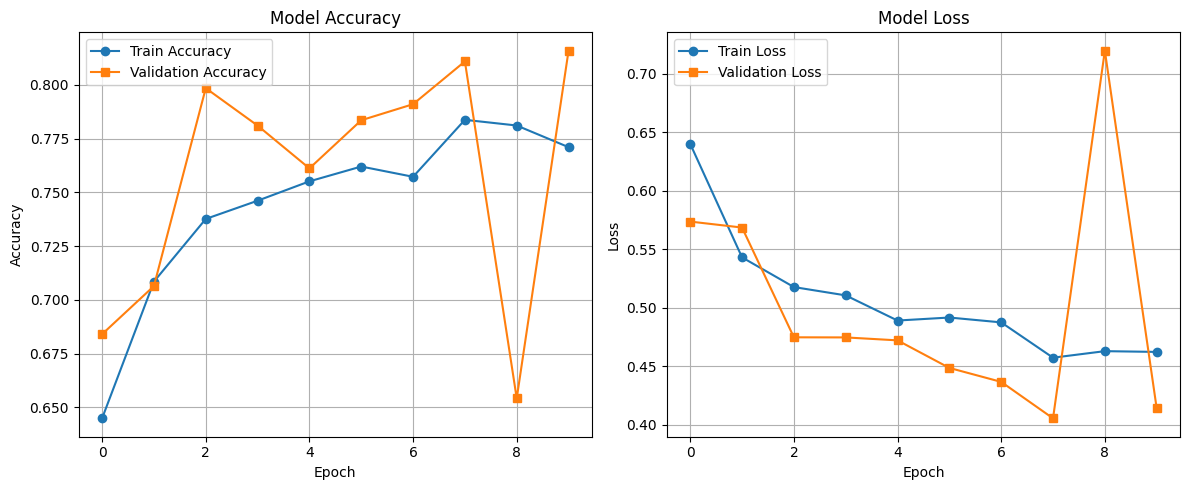

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


X-axis tells Epoch number (how many times the model has seen the entire training dataset).

Y-axis tells Accuracy (how well the model is predicting).

Train Accuracy : Accuracy on the training data.

Validation Accuracy : Accuracy on the validation data (used to test generalization).

X-axis tells Epoch number.

Y-axis tells Loss (a measure of error — lower is better).

Train Loss : Loss on training data.

Validation Loss : Loss on validation data.